In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

### Loading File

In [16]:
df = pd.read_csv('HW3_qatar_tsp.txt',skiprows=7, skipfooter=1, sep='\s',engine='python', names = ['Loc','Lat','Lon'])
df.head()

,Loc,Lat,Lon
0,1,24748.3333,50840.0000
1,2,24758.8889,51211.9444
2,3,24827.2222,51394.7222
3,4,24904.4444,51175.0000
4,5,24996.1111,51548.8889


In [17]:
df['Lat'] = df['Lat']/1000.0
df['Lon'] = df['Lon']/1000.0
df.head()

,Loc,Lat,Lon
0,1,24.748333,50.840000
1,2,24.758889,51.211944
2,3,24.827222,51.394722
3,4,24.904444,51.175000
4,5,24.996111,51.548889


## 2b
### Function to find out distance between two points based on latitude and longitude

In [18]:
R = 6373.0 # approximate radius of earth in km

def get_distance(la1,lo1,la2,lo2):
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

print("Result:", get_distance(52.2296756, 21.0122287, 52.406374, 16.9251681))
print("Should be:", 278.546, "km")

Result: 278.54558935106695
Should be: 278.546 km


### Creating distance matrix
Distance matrix keeps distance between eah point in dataset.

In [19]:
dist_matrix = []
for i in df['Loc'].values:
    arr1 = []
    la1,lo1 = df.iloc[i-1]['Lat'],df.iloc[i-1]['Lon']
    for j in df['Loc'].values:
        la2,lo2 = df.iloc[j-1]['Lat'],df.iloc[j-1]['Lon']
        distance = get_distance(la1,lo1,la2,lo2)
        arr1.append(distance)
    dist_matrix.append(arr1)

### Actual Logic which uses OR Tools to find out best path and prints it.
Code is inspired from OR Tools documentation.

In [20]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = dist_matrix # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, assignment):
    """Prints assignment on console."""
    print('Objective: {} kms'.format(assignment.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}kms\n'.format(route_distance)


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(manager, routing, assignment)
    return assignment

if __name__ == '__main__':
    assignment=main()

Objective: 953 kms
Route for vehicle 0:
 0 -> 5 -> 7 -> 15 -> 12 -> 22 -> 24 -> 70 -> 81 -> 61 -> 58 -> 35 -> 62 -> 19 -> 64 -> 84 -> 85 -> 97 -> 89 -> 88 -> 93 -> 98 -> 100 -> 103 -> 110 -> 129 -> 133 -> 131 -> 126 -> 124 -> 125 -> 113 -> 112 -> 108 -> 101 -> 86 -> 79 -> 75 -> 77 -> 74 -> 71 -> 73 -> 68 -> 59 -> 32 -> 44 -> 56 -> 63 -> 69 -> 76 -> 78 -> 80 -> 82 -> 87 -> 91 -> 96 -> 94 -> 95 -> 92 -> 90 -> 102 -> 105 -> 104 -> 107 -> 106 -> 117 -> 121 -> 118 -> 136 -> 139 -> 144 -> 155 -> 160 -> 162 -> 168 -> 175 -> 181 -> 193 -> 189 -> 191 -> 190 -> 188 -> 187 -> 192 -> 184 -> 170 -> 165 -> 159 -> 161 -> 157 -> 158 -> 164 -> 167 -> 166 -> 169 -> 179 -> 177 -> 176 -> 180 -> 183 -> 186 -> 185 -> 182 -> 174 -> 172 -> 173 -> 178 -> 171 -> 163 -> 148 -> 145 -> 141 -> 137 -> 138 -> 143 -> 149 -> 153 -> 156 -> 152 -> 151 -> 140 -> 146 -> 150 -> 154 -> 147 -> 142 -> 135 -> 130 -> 128 -> 134 -> 132 -> 127 -> 123 -> 122 -> 119 -> 120 -> 116 -> 115 -> 114 -> 111 -> 109 -> 99 -> 83 -> 67 -> 65 -

## 2d
### Storing path generated above in array and using it for plotting
Please make a note og distance found is 953 kms

In [21]:
points = np.array([ 0 , 5 , 7 , 15 , 12 , 22 , 24 , 70 , 81 , 61 , 58 , 35 , 62 , 19 , 64 , 84 , 85 , 97 , 89 , 88 ,
                   93 , 98 , 100 , 103 , 110 , 129 , 133 , 131 , 126 , 124 , 125 , 113 , 112 , 108 , 101 , 86 , 79 ,
                   75 , 77 , 74 , 71 , 73 , 68 , 59 , 32 , 44 , 56 , 63 , 69 , 76 , 78 , 80 , 82 , 87 , 91 , 96 ,
                   94 , 95 , 92 , 90 , 102 , 105 , 104 , 107 , 106 , 117 , 121 , 118 , 136 , 139 , 144 , 155 , 160 ,
                   162 , 168 , 175 , 181 , 193 , 189 , 191 , 190 , 188 , 187 , 192 , 184 , 170 , 165 , 159 , 161 ,
                   157 , 158 , 164 , 167 , 166 , 169 , 179 , 177 , 176 , 180 , 183 , 186 , 185 , 182 , 174 , 172 ,
                   173 , 178 , 171 , 163 , 148 , 145 , 141 , 137 , 138 , 143 , 149 , 153 , 156 , 152 , 151 , 140 , 146 ,
                   150 , 154 , 147 , 142 , 135 , 130 , 128 , 134 , 132 , 127 , 123 , 122 , 119 , 120 , 116 , 115 ,
                   114 , 111 , 109 , 99 , 83 , 67 , 65 , 72 , 66 , 60 , 47 , 51 , 45 , 42 , 40 , 37 , 39 , 33 , 34 ,
                   30 , 31 , 29 , 41 , 43 , 48 , 49 , 54 , 53 , 52 , 55 , 57 , 46 , 50 , 38 , 36 , 26 , 21 ,
                   28 , 27 , 17 , 20 , 23 , 25 , 16 , 13 , 10 , 6 , 8 , 9 , 11 , 18 , 14 , 4 , 2 , 1 , 3 , 0])
#points = points + 1

In [22]:
lon_lat = df[['Lat','Lon']].values[points]

([], <a list of 0 Text yticklabel objects>)

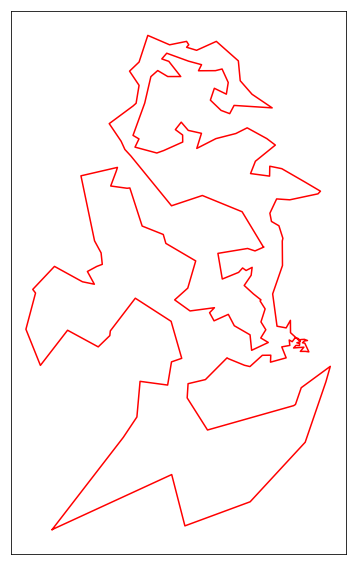

In [29]:
plt.figure(figsize = (6,10))
plt.plot(lon_lat.T[1],lon_lat.T[0], c='red');
plt.xticks([])
plt.yticks([])